In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sc
import seaborn as sns
import math
import json
import random
from sklearn.model_selection import train_test_split
import joblib
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier

In [84]:
with open('../datasets/dryer_labels.txt', 'r') as f:
    lines = f.readlines()
for line in lines:
    print(line)

Energy Rating Data Dictionary for Clothes Dryers (labelled) as at May 2015



Column - Column Identifier - Description

ApplStandard - Registration.regulatory_standard - This is the legal standard to which the appliance must comply

Brand - Model.brand_name - This is the manufacturers brand

Combination - is_combination_washer_dryer - The appliance may be a combination washer/dryer

Control	- control - select appropriate type from the list

Country - Registration.registrationmanufacturingcountry_set - Country of manufacture

Depth - dimension_depth - Insert overall dimension in mm

Height - dimension_height - Insert overall dimension in mm

Model Name - Registration.get_model_name_display_display - Model name

Model No - Model.model_number - Model number

N-Standard - Registration.test_standard - This is the test standard used for the appliance, usually denoted with the prefix AS/NZS xxxxxxx

New CEC - cec - This is the current Comparative Energy Consumption of the product which is its

In [85]:
data = pd.read_csv('../datasets/dryer.csv')
ranges = {}
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 32 columns):
ApplStandard                397 non-null object
Brand                       397 non-null object
Cap                         397 non-null float64
Combination                 397 non-null bool
Control                     397 non-null object
Country                     397 non-null object
Depth                       223 non-null float64
Height                      223 non-null float64
Model No                    397 non-null object
Family Name                 106 non-null object
N-Standard                  397 non-null object
New CEC                     397 non-null int64
New SRI                     397 non-null float64
New Star                    397 non-null float64
Prog Name                   397 non-null object
Prog Time                   397 non-null float64
Sold_in                     387 non-null object
SubmitStatus                397 non-null object
Submit_ID                   

In [86]:
# Let us first find see the features which we might have to drop
print(data.columns.values)

# As we can see here, Grand Date and Old Star Rating are entirely empty so we can drop them
print(data.isnull().sum(), '\n')

# For each of these features, more than 97% of the values are the same, we can drop these as well
print(pd.value_counts(data['N-Standard']), '\n')
print(pd.value_counts(data['SubmitStatus']), '\n')
print(pd.value_counts(data['Product Class']), '\n')
print(pd.value_counts(data['Availability Status']), '\n')

# Since we are also finding the star index of appliances which have passed their expiry date, we will remove that as well
columns = ['Model No', 'Family Name', 'Sold_in', 'N-Standard', 'SubmitStatus', 'Submit_ID', 'GrandDate', 'Product Class', 'Product Website', 'Old Star Rating', 'Star Image Large', 'Star Image Small', 'Availability Status', 'Representative Brand URL', 'ExpDate']

# Dropping the columns
data.drop(columns, axis=1, inplace=True)
print(data.head(4), '\n')
print(data.info())

['ApplStandard' 'Brand' 'Cap' 'Combination' 'Control' 'Country' 'Depth'
 'Height' 'Model No' 'Family Name' 'N-Standard' 'New CEC' 'New SRI'
 'New Star' 'Prog Name' 'Prog Time' 'Sold_in' 'SubmitStatus' 'Submit_ID'
 'Test_Moist_Remove' 'Tot_Wat_Cons' 'Type' 'Width' 'ExpDate' 'GrandDate'
 'Product Class' 'Availability Status' 'Product Website'
 'Representative Brand URL' 'Old Star Rating' 'Star Image Large'
 'Star Image Small']
ApplStandard                  0
Brand                         0
Cap                           0
Combination                   0
Control                       0
Country                       0
Depth                       174
Height                      174
Model No                      0
Family Name                 291
N-Standard                    0
New CEC                       0
New SRI                       0
New Star                      0
Prog Name                     0
Prog Time                     0
Sold_in                      10
SubmitStatus               

In [87]:
# Fill up missing value columns
missing_values_columns = [column for column in data.columns.values if data[column].isnull().sum()>0]
print(missing_values_columns)

['Depth', 'Height', 'Tot_Wat_Cons', 'Width']


In [88]:
# Firstly we shall combine Brand and Country into a single column
Brand_Country = []
for index, row in data.iterrows():
    if len(row['Country'])>1: 
        Brand_Country.append((row['Brand'][:2] + row['Country'][0][:1] + row['Country'][1][:1]).upper())
    else: 
        Brand_Country.append((row['Brand'][:2] + row['Country'][0][:1]).upper())
data['Brand_Country'] = Brand_Country
data['Brand_Country']

0      NOCH
1      TUCH
2      ACCH
3      TRCH
4      INIT
5      INIT
6      INIT
7      ARIT
8      ARIT
9      ARIT
10     MIGE
11     LGSO
12     MIGE
13     BOPO
14     LGSO
15     ASSL
16     FICH
17     FICH
18     CECH
19     CECH
20     CECH
21     CECH
22     EUTU
23     SASO
24     GACH
25     GACH
26     SHCH
27     PYCH
28     SASO
29     STCH
       ... 
367    INCH
368    INCH
369    INCH
370    INCH
371    BLCH
372    SACH
373    ELTH
374    ELTH
375    GOSL
376    HISL
377    HISL
378    EUCH
379    ELPO
380    OMCH
381    KOCH
382    KOCH
383    KOCH
384    KOCH
385    INCH
386    BOPO
387    SIPO
388    BOPO
389    PRCH
390    MIGE
391    EUCH
392    EVCH
393    MICH
394    MIGE
395    MIGE
396    MIGE
Name: Brand_Country, Length: 397, dtype: object

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


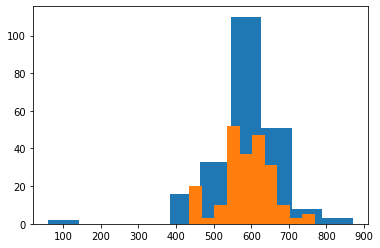

0.0      174
555.0     26
622.0     13
615.0     12
435.0     12
545.0     11
630.0     10
580.0     10
600.0      9
640.0      8
595.0      7
535.0      6
690.0      6
660.0      6
550.0      5
585.0      5
625.0      5
636.0      5
540.0      5
643.0      5
582.0      4
565.0      4
530.0      4
465.0      4
755.0      3
440.0      3
665.0      3
609.0      3
645.0      2
60.0       2
870.0      2
610.0      2
700.0      2
605.0      1
726.0      1
675.0      1
670.0      1
767.0      1
598.0      1
495.0      1
835.0      1
620.0      1
650.0      1
560.0      1
438.0      1
770.0      1
480.0      1
714.0      1
470.0      1
590.0      1
637.0      1
711.0      1
Name: Depth, dtype: int64
2    130
1    117
3     92
0     58
Name: Depth, dtype: int64


In [89]:
plt.hist(data.Depth)
plt.hist(data.loc[(data.Depth>400) & (data.Depth<800), 'Depth'])
plt.show()

# To fill missing values in Depth
mode_depth_overall = data['Depth'].value_counts().index[0]
data['Depth'] = data['Depth'].fillna(0)
print(data.Depth.value_counts())
for index, row in data.iterrows():
    if int(row['Depth']) == 0:
        brand_country_mode = int(data.loc[data['Brand_Country']==row['Brand_Country']]['Depth'].mode().values[0])
        country_mode = int(data.loc[data['Country']==row['Country']]['Depth'].mode().values[0])
        if brand_country_mode!=0:
            depth = brand_country_mode
        elif country_mode!=0:
            depth = country_mode
        else: 
            depth = mode_depth_overall
    else: 
        depth = int(data.at[index, 'Depth'])
    
    if depth>=60 and depth<=550: value = 0
    elif depth==555: value = 1
    elif depth>=560 and depth<=700: value = 2
    else: value = 3
    data.at[index, 'Depth'] = value
    
data['Depth'] = data['Depth'].astype(int)
print(data['Depth'].value_counts())
# len(data[(data['Depth']>450) & (data['Depth']<600)])

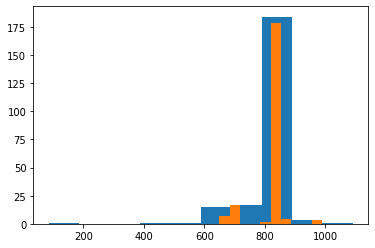

0.0       174
850.0      88
840.0      38
845.0      34
700.0      17
846.0      13
595.0       6
830.0       5
670.0       4
860.0       4
650.0       2
600.0       2
990.0       2
800.0       2
560.0       1
982.0       1
435.0       1
671.0       1
1092.0      1
85.0        1
Name: Height, dtype: int64


2    134
4    103
3     89
1     69
0      2
Name: Height, dtype: int64

In [90]:
plt.hist(data.Height)
plt.hist(data.loc[(data.Height>600) & (data.Height<1000), 'Height'])
plt.show()

# To fill missing values in Height
mode_height_overall = data['Height'].value_counts().index[1]
data['Height'] = data['Height'].fillna(0)
print(data.Height.value_counts())
for index, row in data.iterrows():
    if int(data.at[index, 'Height']) == 0:
        brand_country_mode = int(data.loc[data['Brand_Country']==row['Brand_Country']]['Height'].mode().values[0])
        country_mode = int(data.loc[data['Country']==row['Country']]['Height'].mode().values[0])
        if brand_country_mode!=0:
            height = brand_country_mode
        elif country_mode!=0:
            height = country_mode
        else: 
            height = mode_depth_overall
    else: 
        height = int(data.at[index, 'Height'])
    
    if height>=85 and height<=550: value = 0
    elif height==555: value = 1
    elif height>=560 and height<850: value = 2
    elif height==850: value = 3
    else: value = 4
    data.at[index, 'Height'] = value
data['Height'] = data['Height'].astype(int)
data['Height'].value_counts()

In [91]:
# For total water consumption, since the mode value is 0 by a very large margin, 
# we will fill the empty values with 0
data['Tot_Wat_Cons'] = data['Tot_Wat_Cons'].fillna(0)
data['Tot_Wat_Cons'] = data['Tot_Wat_Cons'].astype(int)
print(data.Tot_Wat_Cons.value_counts())
for index, rows in data.iterrows():
    water_cons = data.at[index, 'Tot_Wat_Cons']
    if water_cons==0: value = 0
    else: value = 1
    data.at[index, 'Tot_Wat_Cons'] = value
data.Tot_Wat_Cons = data.Tot_Wat_Cons.astype(int)
data.Tot_Wat_Cons.value_counts()

0      329
33       9
25       7
42       6
16       3
1        3
23       3
22       2
41       2
46       2
21       2
100      2
58       2
72       2
29       1
19       1
14       1
12       1
6        1
4        1
3        1
18       1
147      1
35       1
37       1
142      1
47       1
48       1
50       1
52       1
53       1
57       1
65       1
67       1
71       1
88       1
39       1
Name: Tot_Wat_Cons, dtype: int64


0    329
1     68
Name: Tot_Wat_Cons, dtype: int64

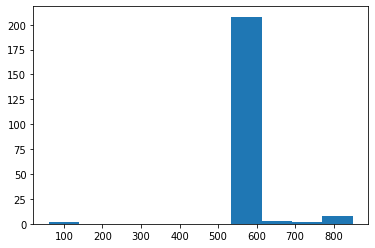

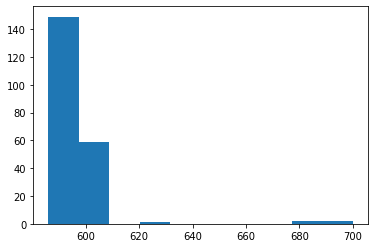

0.0      174
595.0    132
600.0     59
596.0     12
850.0      6
597.0      4
700.0      2
830.0      2
60.0       2
586.0      1
630.0      1
683.0      1
686.0      1
Name: Width, dtype: int64


1    208
0    102
2     87
Name: Width, dtype: int64

In [92]:
plt.hist(data.Width)
plt.show()
plt.hist(data.loc[(data.Width>500) & (data.Width<800), 'Width'])
plt.show()

# To fill missing values in Width
mode_height_overall = data['Width'].value_counts().index[0]
data['Width'] = data['Width'].fillna(0)
print(data.Width.value_counts())
for index, row in data.iterrows():
    if int(row['Width']) == 0:
        brand_country_mode = int(data.loc[data['Brand_Country']==row['Brand_Country']]['Width'].mode().values[0])
        country_mode = int(data.loc[data['Country']==row['Country']]['Width'].mode().values[0])
        if brand_country_mode!=0:
            width = brand_country_mode
        elif country_mode!=0:
            width = country_mode
        else: 
            width = mode_depth_overall
    else: 
        width = int(data.at[index, 'Width'])
    
    if width>=60 and width<595: value = 0
    elif width==595: value = 1
    elif width>=600 and width<850: value = 2
    data.at[index, 'Width'] = value
data['Width'] = data['Width'].astype(int)
data.Width.value_counts()

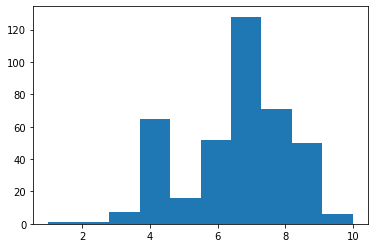

7.0     119
8.0      70
9.0      44
4.5      41
6.0      41
4.0      24
5.0      16
5.5      11
6.5       9
8.5       6
3.5       6
10.0      6
7.5       1
1.0       1
3.0       1
2.5       1
Name: Cap, dtype: int64


1    196
0    151
2     50
Name: Cap, dtype: int64

In [93]:
plt.hist(data.Cap)
plt.show()

# Converting Cap to integer classes
print(data.Cap.value_counts())
for index, rows in data.iterrows():
    capacity = int(data.at[index, 'Cap'])
    if capacity>=1 and capacity<=6: value = 0
    elif capacity>=7 and capacity<=8: value = 1
    else: value = 2
    data.at[index, 'Cap'] = value    
data['Cap'] = data['Cap'].astype(int)

ranges['Cap'] = {0:(1,6), 1:(7,8), 2:(9,10)}

data.Cap.value_counts()

In [94]:
# Converting New Star rating to Integer Classes
data['New Star'] = data['New Star'].astype(int)
print(data['New Star'].value_counts())
for index, rows in data.iterrows():
    star = data.at[index, 'New Star']
    if star==1 : value = 0
    elif star == 2: value = 1
    elif star>=3: value = 2
    data.at[index, 'New Star'] = value

data['New Star'].value_counts()

2     215
3      38
1      38
7      30
6      30
8      23
9      15
4       5
10      2
5       1
Name: New Star, dtype: int64


1    215
2    144
0     38
Name: New Star, dtype: int64

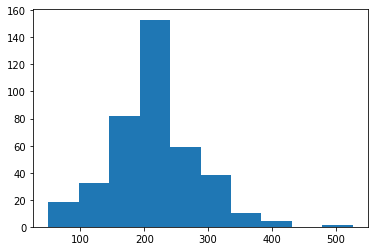

200    18
198    12
210    12
208    12
216    11
90     10
230     9
220     9
187     8
280     7
140     7
290     7
114     6
162     6
170     6
150     6
283     6
186     6
160     5
215     5
310     5
164     5
202     5
196     4
275     4
271     4
209     4
135     4
58      4
180     4
       ..
227     1
228     1
254     1
251     1
232     1
233     1
235     1
237     1
243     1
244     1
386     1
266     1
292     1
268     1
175     1
178     1
182     1
185     1
250     1
285     1
188     1
191     1
192     1
282     1
278     1
276     1
203     1
273     1
270     1
526     1
Name: Prog Time, Length: 142, dtype: int64


3    72
5    55
4    52
2    45
7    43
6    43
8    31
1    29
0    27
Name: Prog Time, dtype: int64

In [95]:
plt.hist(data['Prog Time'])
plt.show()

# Converting Prog Time to integer classes
data['Prog Time'] = data['Prog Time'].astype(int)
print(data['Prog Time'].value_counts())
for index, rows in data.iterrows():
    time = data.at[index, 'Prog Time']
    if time>=50 and time<=115 : value = 0
    elif time>115 and time<=150: value = 1
    elif time>150 and time<=175: value = 2
    elif time>175 and time<=200: value = 3
    elif time>200 and time<=215: value = 4
    elif time>215 and time<=235: value = 5
    elif time>235 and time<=275: value = 6
    elif time>275 and time<=300: value = 7
    elif time>300: value = 8
    data.at[index, 'Prog Time'] = value

ranges['Prog Time'] = {0:(50,115),1:(115,150),2:(150,175),3:(175,200),4:(200,215),5:(215,235),6:(235,275),7:(275,300),8:(300,500)}
    
data['Prog Time'].value_counts()

In [96]:
# Since the common mass removed is 5, we shall keep that as a integer category,
# along with the ones below and above it
data['Test_Moist_Remove'] = data['Test_Moist_Remove'].astype(int)
print(data.Test_Moist_Remove.value_counts())
for index, rows in data.iterrows():
    moist = data.at[index, 'Test_Moist_Remove']
    if moist<5 : value = 0
    elif moist==5: value = 1
    elif moist>5: value = 2
    data.at[index, 'Test_Moist_Remove'] = value
data.Test_Moist_Remove.value_counts()

5       131
3        75
6        74
4        59
7        47
2         6
4844      1
9         1
8         1
1         1
0         1
Name: Test_Moist_Remove, dtype: int64


0    142
1    131
2    124
Name: Test_Moist_Remove, dtype: int64

In [97]:
# Converting CEC into smaller integer classes using feature scaling
data['New CEC'] = data['New CEC'].astype(int)
cec_range = data['New CEC'].max() - data['New CEC'].min()
cec_mean = data['New CEC'].mean()
for index, rows in data.iterrows():
    cec = (data.at[index, 'New CEC'] - cec_mean)/cec_range
    if cec>-0.5 and cec<=-0.25: value = 0
    elif cec>-0.25 and cec<=-0.175: value = 1
    elif cec>-0.175 and cec<=-0.15: value = 2
    elif cec>-0.15 and cec<=-0.05: value = 3
    elif cec>-0.05 and cec<=0: value = 4
    elif cec>0 and cec<=0.15: value = 5
    elif cec>0.15 and cec<=0.25: value = 6
    elif cec>0.25 and cec<=0.5: value = 7
    else: value = 8
    data.at[index, 'New CEC'] = value

forms = [[-0.5,-0.25],[-0.25,-0.175],[-0.175,-0.15],[-0.15,-0.05],[-0.05,0],[0,0.15],[0.15,0.25],[0.25,0.5]]
ranges['New CEC'] = {}
for i in range(len(forms)):
    ranges['New CEC'][str(i)] = [forms[i][0]*cec_range+cec_mean, forms[i][1]*cec_range+cec_mean]

data['New CEC'].value_counts()

6    73
5    73
1    70
3    65
7    43
0    36
4    18
2    17
8     2
Name: New CEC, dtype: int64

In [98]:
# We shall extract the features fro the Program Name and seperate them into different classes
def return_features(data, index):
    program = data.at[index, 'Prog Name']
    if '/' in program:
        types = program.split('/')
        program = ''
        for t in types:
            program+=t+' '
    if ',' in program:
        types = program.split(',')
        program = ''
        for t in types:
            program+=t+' '
    keywords = program.split(' ')
    features = []
    for i in keywords: 
        i = i.strip()
        if i not in ['', '-']: features.append(i.lower())
    print(index, features)
    return features
    
for i, row in data.iterrows():
    features = return_features(data, i)
    if 'dry' in features and 'heat' in features: data.at[i, 'Prog Name'] = 0
    elif 'heat' in features: data.at[i,'Prog Name'] = 1
    elif 'dry' in features: data.at[i, 'Prog Name'] = 2
    else: data.at[i, 'Prog Name'] = 3

data['Prog Name'] = data['Prog Name'].astype(int)
data['Prog Name'].value_counts()

0 ['strong', 'heat']
1 ['extra', 'dry', 'full', 'load']
2 ['extra', 'dry', 'full', 'load']
3 ['extra', 'dry', 'full', 'load']
4 ['11', 'cottons', 'cupboard', 'dry']
5 ['11', 'cottons', 'cupboard', 'dry']
6 ['11', 'cottons', 'cupboard', 'dry']
7 ['11', 'cotton', 'cupboard', 'dry']
8 ['11', 'cotton', 'cupboard', 'dry']
9 ['11', 'cotton', 'cupboard', 'dry']
10 ['cottons', 'normal', '+']
11 ['cotton', 'cupboard']
12 ['cottons', 'extra', 'dry']
13 ['cottons', 'cupboard', 'dry', 'extra']
14 ['cotton', 'cupboard']
15 ['auto', 'normal', 'dry']
16 ['everyday']
17 ['everyday']
18 ['extra', 'dry', 'full', 'heat']
19 ['extra', 'dry', 'full', 'heat']
20 ['extra', 'dry', 'full', 'heat']
21 ['extra', 'dry', 'full', 'heat']
22 ['cotton', 'extra', 'dry']
23 ['drying', 'cotton', 'extra', 'dry', 'drying', 'level', 'high']
24 ['strong']
25 ['strong']
26 ['full', 'heat']
27 ['full', 'heat', 'extra', 'dry']
28 ['drying', 'cotton', 'extra', 'dry', 'drying', 'level', 'high']
29 ['regular', 'extra', 'dry', 'pr

2    219
3    147
1     17
0     14
Name: Prog Name, dtype: int64

In [99]:
# As we can see we have removed all the null values are removed, now we must convert all the other data type
# to int type, by mapping boolean and objects to int
ApplStandard_types = {'AS/NZS 2442.2:2000/Amdt 2:2007 (Legacy)': 0, 'Greenhouse and Energy Minimum Standards (Rotary Clothes Dryers) Determination 2012': 1, 'Greenhouse and Energy Minimum Standards (Rotary Clothes Dryers) Determination 2015': 2, 'AS/NZS 2442.2:2000/Amdt 2:2007': 3}
data['ApplStandard'] = data['ApplStandard'].map(ApplStandard_types).astype(int)
data['Combination'] = data['Combination'].map({False: 0, True: 1}).astype(int)
data['Control'] = data['Control'].map({'Timer': 0, 'Autosensing': 1, 'Manual': 2}).astype(int)
data['Type'] = data['Type'].map({'Condenser': 0, 'Vented': 1}).astype(int)

ranges['Combination'] = {0: ['False'], 1: ['True']}
ranges['Type'] = {0: ['Condensor'], 1: ['Vented']}

# We have converted all the initial types into integer type
# For now we shall not consider the effects of Brand_country, Brand and Country
data.drop(['Brand_Country', 'Brand', 'Country', 'New SRI'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 14 columns):
ApplStandard         397 non-null int64
Cap                  397 non-null int64
Combination          397 non-null int64
Control              397 non-null int64
Depth                397 non-null int64
Height               397 non-null int64
New CEC              397 non-null int64
New Star             397 non-null int64
Prog Name            397 non-null int64
Prog Time            397 non-null int64
Test_Moist_Remove    397 non-null int64
Tot_Wat_Cons         397 non-null int64
Type                 397 non-null int64
Width                397 non-null int64
dtypes: int64(14)
memory usage: 43.5 KB


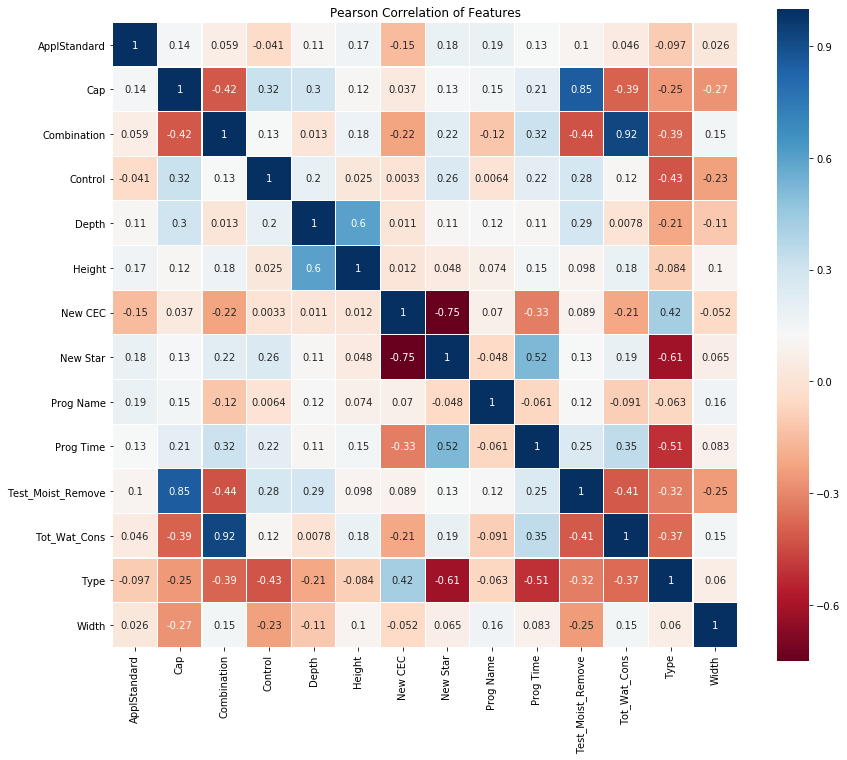

In [100]:
# We will plot a heatmap to watch the correlation of features with one another and tend to observe if there 
# are any redundant features etc
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features')
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=plt.cm.RdBu, annot=True)

In [101]:
# As we can see from the heatmap plot below, Test_Moist_Remove and Capacity show high Correlation,
# So does Combination and Tot_Wat_Cons - Thus we can drop one of each pairs of correlated columns
data.drop(['Tot_Wat_Cons', 'Test_Moist_Remove'], axis=1, inplace=True)
data.head(3)

,ApplStandard,Cap,Combination,Control,Depth,Height,New CEC,New Star,Prog Name,Prog Time,Type,Width
0,0,0,0,0,1,1,3,1,1,3,1,1
1,0,0,0,1,3,2,5,1,2,5,1,2
2,0,0,0,1,1,1,5,1,2,5,1,1


In [102]:
train_x = data.drop('New Star', axis=1)
train_y = data['New Star']
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2, random_state=1)

train_x

,ApplStandard,Cap,Combination,Control,Depth,Height,New CEC,Prog Name,Prog Time,Type,Width
298,2,0,0,1,0,2,5,3,1,1,1
13,2,2,0,1,1,1,2,2,5,0,0
376,2,1,0,1,2,3,6,3,3,0,2
61,1,1,0,1,1,2,6,2,2,0,1
346,2,0,0,0,0,2,3,3,3,1,2
211,2,0,1,1,2,3,1,2,3,0,1
224,2,1,0,1,2,2,0,2,7,0,1
257,2,1,0,1,3,4,6,2,5,1,1
332,2,0,1,1,1,4,3,2,8,0,2
354,2,1,0,1,3,4,1,2,5,0,0


In [103]:
# KNN Neighbours Classification
knn = KNeighborsClassifier(n_neighbors = 3, leaf_size=5, algorithm='ball_tree')
knn.fit(train_x, train_y)  
knn_predictions = knn.predict(train_x)  
knn_accuracy = round(knn.score(train_x, train_y) * 100, 2)
print("Accuracy: " ,knn_accuracy)

print("Precision score: ", precision_score(train_y, knn_predictions, average=None))
print("Recall score: ", recall_score(train_y, knn_predictions, average=None))
print("F Score: ", f1_score(train_y, knn_predictions, average=None))

# Since we are getting a reasonably good score, we can tune this classifier

Accuracy:  94.64
Precision score:  [0.96153846 0.94736842 0.94166667]
Recall score:  [0.73529412 0.95857988 0.99122807]
F Score:  [0.83333333 0.95294118 0.96581197]


In [105]:
knn = KNeighborsClassifier(n_neighbors = 3, leaf_size=5, algorithm='ball_tree')
knn.fit(test_x, test_y)  
knn_predictions = knn.predict(test_x)  
knn_accuracy = round(knn.score(test_x, test_y) * 100, 2)
print("Accuracy: " ,knn_accuracy)

print("Precision score: ", precision_score(test_y, knn_predictions, average=None))
print("Recall score: ", recall_score(test_y, knn_predictions, average=None))
print("F Score: ", f1_score(test_y, knn_predictions, average=None))

Accuracy:  92.5
Precision score:  [0.         0.9        0.96666667]
Recall score:  [0.         0.97826087 0.96666667]
F Score:  [0.         0.9375     0.96666667]


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [106]:
joblib.dump(knn, '../server/weights/dryer_weight.sav')

['../server/weights/dryer_weight.sav']

In [107]:
problemFeatures_for_0 = ['New CEC', 'Prog Time', 'Type', 'Cap', 'Combination']
specifications_for_0 = {}
for feature in problemFeatures_for_0:
    if feature in ['Combination','Type'] : specifications_for_0[feature] = list(data.loc[data['New Star']==0, feature].value_counts().index[:1])
    else: specifications_for_0[feature] = list(data.loc[data['New Star']==0, feature].value_counts().index[:3])
print(specifications_for_0)

ranges['specifications_for_0'] = specifications_for_0

{'New CEC': [7, 6, 5], 'Prog Time': [0, 5, 1], 'Type': [1], 'Cap': [1, 2, 0], 'Combination': [0]}


In [108]:
problemFeatures_for_1 = ['New CEC', 'Prog Time', 'Cap']
specifications_for_1 = {}
for feature in problemFeatures_for_1:
    specifications_for_1[feature] = list(data.loc[data['New Star']==1, feature].value_counts().index[:2])
print(specifications_for_1)

ranges['specifications_for_1'] = specifications_for_1

{'New CEC': [5, 6], 'Prog Time': [3, 4], 'Cap': [1, 0]}


In [109]:
problemFeatures_for_2 = ['New CEC', 'Prog Time', 'Type', 'Cap', 'Combination']
specifications_for_2 = {}
for feature in problemFeatures_for_2:
    if feature in ['Combination','Type'] : specifications_for_2[feature] = list(data.loc[data['New Star']==2, feature].value_counts().index[:1])
    else: specifications_for_2[feature] = list(data.loc[data['New Star']==2, feature].value_counts().index[:2])
print(specifications_for_2)

ranges['specifications_for_2'] = specifications_for_2

{'New CEC': [1, 0], 'Prog Time': [7, 6], 'Type': [0], 'Cap': [1, 0], 'Combination': [0]}


In [111]:
# file = open('../server/inferences/data_ranges/dryer.json','w')
# json.dump(ranges,file)